In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import re
import sys
sys.path.append('src/')
from src.similarities_computation import run_similarity_analysis
from src.data_processing import extract_ranges, fill_singleton_dimensions
from src.data_visualisation import plot_scatter_for_variable_groups

# Task 2

In [2]:
# Read the files
task1_path = Path.cwd() / 'resources' / 'task_2'
df_properties = pd.read_csv(task1_path / 'reference_properties.tsv', sep='\t')
df_rfq = pd.read_csv(task1_path / 'rfq.csv')

In [3]:
df_rfq

,id,grade,grade_suffix,coating,finish,surface_type,surface_protection,form,thickness_min,thickness_max,...,weight_min,weight_max,inner_diameter_min,inner_diameter_max,outer_diameter_min,outer_diameter_max,yield_strength_min,yield_strength_max,tensile_strength_min,tensile_strength_max
0,8aff426d-b8c0-43aa-ad26-835ef4de6129,S700MC,NaN,NaN,Oiled,NaN,NaN,Coils,6.00,6.0,...,15000.0,25000.0,610.0,610.0,NaN,NaN,NaN,NaN,760.0,810.0
1,37e624be-b125-464f-85b6-1838530193ef,S250GD,NaN,ZM310,Hot-dip zinc magnesium (+ZM),NaN,NaN,Slit Coils,1.50,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,b8257184-6307-46ab-b06e-d979336d1263,DX51D,NaN,Z100,Hot-dip Galvanized (+Z/+GI),NaN,Lightly Oiled (L),Coils,0.40,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63140d1f-dda8-40fe-8931-bcaba65d5772,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.50,1.5,...,53800.0,53800.0,NaN,NaN,60.3,NaN,NaN,NaN,NaN,NaN
4,11cffc57-44be-4d79-bfd5-97482be566d3,S235,NaN,NaN,NaN,NaN,NaN,Round Tubes,1.50,1.5,...,14500.0,14500.0,NaN,NaN,48.3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7a965ba4-be4e-4833-a723-1f98ed1f24ac,DX51D,NaN,Z080,Hot-dip Galvanized (+Z/+GI),NaN,NaN,Coils,0.55,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,82fc492f-0adc-49bd-8458-69bb1f0f318e,DD11,NaN,NaN,Hot Rolled,NaN,Pickled and Oiled,Coils,NaN,NaN,...,NaN,25000.0,610.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN
997,d3db6f2f-6218-4612-8a63-c26d4ac69658,S550MC,NaN,NaN,Hot Rolled,NaN,Pickled and Oiled,Coils,3.40,3.6,...,25000.0,35000.0,610.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN
998,90b02a62-3da9-4648-948c-52627d086a50,DD11,NaN,NaN,Hot Rolled,NaN,Pickled and Oiled,Coils,2.40,2.6,...,20000.0,25000.0,610.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# rename propertires columns
column_mapping = {
    'Standards': 'standards',
    'Carbon (C)': 'carbon_C',
    'Manganese (Mn)': 'manganese_Mn', 
    'Silicon (Si)': 'silicon_Si',
    'Sulfur (S)': 'sulfur_S',
    'Phosphorus (P)': 'phosphorus_P',
    'Chromium (Cr)': 'chromium_Cr',
    'Nickel (Ni)': 'nickel_Ni',
    'Molybdenum (Mo)': 'molybdenum_Mo',
    'Vanadium (V)': 'vanadium_V',
    'Aluminum (Al)': 'aluminum_Al',
    'Titanium (Ti)': 'titanium_Ti',
    'Niobium (Nb)': 'niobium_Nb',
    'Boron (B)': 'boron_B',
    'Nitrogen (N)': 'nitrogen_N',
    'Tensile strength (Rm)': 'tensile_strength_Rm',
    'Yield strength (Re or Rp0.2)': 'yield_strength_RE_RP0.2', 
    'Elongation (A%)': 'elongation_A%',
    'Hardness (HB, HV, HRC)': 'hardness_HB_HV_HRC',
    'Impact toughness (Charpy V-notch)': 'impact_toughness_Charpy_V_notch',
    'Source_Pages': 'source_pages',
    'Application': 'application',
    'Category': 'category',
    'Nb + V + Ti (Others)': 'Nb_V_Ti_others',
    'Coating': 'coating'
}

df_properties = df_properties.rename(columns=column_mapping)

### Fix inconsistencies in grade

In [5]:
# Fix inconsistencies in grade
df_properties['Grade/Material'] = df_properties['Grade/Material'].replace({
    'HC380La': 'HC380LA',
    '26Mnb5': '26MnB5',
    'CR440Y780T DP': 'CR440Y780T-DP'
})

df_rfq['grade'] = df_rfq['grade'].replace({
    'HC380La': 'HC380LA',
    '26Mnb5': '26MnB5',
    'CR440Y780T DP': 'CR440Y780T-DP'
})

# Drop duplicates
df_properties = df_properties.drop_duplicates(subset=['Grade/Material'], keep='first')


In [6]:
# join datasets
df_merged = df_rfq.merge(
    df_properties, 
    left_on='grade',          
    right_on='Grade/Material', 
    how='left'
)

In [7]:
# check for missing grades matches
matches_found = False
for i in range(len(df_merged)):
    if df_merged.loc[i, 'grade'] is not np.nan and pd.isna(df_merged.loc[i, 'Grade/Material']):
        print(f"Row {i} has no match: {df_merged.loc[i, 'grade']}")
        matches_found = True

if not matches_found:
    print("All grades in rfq have a match in reference_properties.")
    df_merged.drop(columns=['Grade/Material'], inplace=True)

All grades in rfq have a match in reference_properties.


In [8]:
# Drop rows with missing grades
df_merged = df_merged.dropna(subset=['grade'])

# Drop empty columns
empty_cols = df_merged.columns[df_merged.isnull().all()].tolist()
df_merged = df_merged.drop(columns=empty_cols)

# Drop uninformative or wrong columns
cols_to_drop = ["height_max"]
df_merged = df_merged.drop(columns=cols_to_drop)

# Fix wrong column naming (height_min should be length_max)
df_merged = df_merged.rename(columns={'height_min': 'length_max'})

### Process Categorical Variables.  

Assumptions:
- missing values refers to standard features or to missing additional processing. Hence I set these empty values equal to nan



In [9]:
# Set missing data categorical columns as 'N/A'
categorical_cols = ["surface_protection", "coating_x", "form", "surface_type", "finish"]
for col in categorical_cols:
    df_merged.loc[df_merged[col].isna(), col] = np.nan

### Process Grade Properites

- When a biund is found, I set this equal to min and max

In [10]:
cols_with_ranges = [
    'carbon_C',
    'manganese_Mn',
    'silicon_Si',
    'sulfur_S',
    'phosphorus_P',
    'chromium_Cr',
    'nickel_Ni',
    'molybdenum_Mo',
    'vanadium_V',
    'aluminum_Al',
    'titanium_Ti',
    'niobium_Nb',
    'boron_B',
    'nitrogen_N',
    'tensile_strength_Rm',
    'yield_strength_RE_RP0.2',
    'elongation_A%',
    'hardness_HB_HV_HRC',
    'Nb_V_Ti_others'
]


for col in cols_with_ranges:
    df_merged = extract_ranges(df_merged, col)

Unexpected value format: Variable found in variable carbon_C at row 722
Unexpected value format: Variable found in variable manganese_Mn at row 722
Unexpected value format: 0.50 found in variable silicon_Si at row 589
Unexpected value format: Variable found in variable silicon_Si at row 722
Unexpected value format: 415 MPa found in variable tensile_strength_Rm at row 589
Unexpected value format: Variable found in variable tensile_strength_Rm at row 722
Unexpected value format: 205 MPa found in variable yield_strength_RE_RP0.2 at row 589


### Process Dimensions

Approach
- There are 138 missing data for forms. I tried to input some of them by using inner_diameter_min which is a dimension existent only for Coils, Strpis, and Slit Coils. However, it is not clear to which of these 3 groups should the missing values be inputted. I furtherly assessed the 'width_min' dimension to look for informative variables as I thought it could help discriminate between different coils types. Also here a found hogh variability and gived up this approach.
- I choose to input 


In [11]:
# assess missing values

print(df_merged.loc[df_merged['thickness_min'].isna(), "form"].value_counts())

form
Coils                72
Round Bars           12
Strips               10
Slit Coils            9
Sheets                3
I-Sections            3
H-Sections            2
Rectangular Tubes     1
Name: count, dtype: int64


In [12]:
# Fix outer_diameter values

# outer_diameter = 610.0 is a mistake, it should be inner_diameter 
mask = df_merged['form'][df_merged['outer_diameter_min'] == 610.0].index
df_merged.loc[mask, ['inner_diameter_min', 'inner_diameter_max']] = 610.0
df_merged.loc[mask, ['outer_diameter_min', 'outer_diameter_max']] = np.nan

# Set threshold for outer diameter
threshold = 2000
mask = df_merged['form'][df_merged['outer_diameter_min'] > threshold].index
df_merged.loc[mask, ['outer_diameter_min', 'outer_diameter_max']] = np.nan

In [13]:
# Inputting missing values for inner_diameter_min and inner_diameter_max
print('- Inspecting inner_diameter_min values equal to 610.0')
print(df_merged.loc[df_merged['inner_diameter_min'] == 610.0, "form"].value_counts())
print('\n- Values with inner_diameter_min equal to 610.0 are only Coils, Slit Coils, and Strips.\n--> I decided to impute inner_diameter missing values for these 3 forms with 610.0')

inner_diameter_mask = (df_merged['form'].isin(['Coils', 'Slit Coils', 'Strips']) & 
        df_merged['inner_diameter_min'].isna())

df_merged.loc[inner_diameter_mask, 'inner_diameter_min'] = 610
df_merged.loc[inner_diameter_mask, 'inner_diameter_max'] = 610

- Inspecting inner_diameter_min values equal to 610.0
form
Coils         156
Slit Coils     11
Strips          5
Name: count, dtype: int64

- Values with inner_diameter_min equal to 610.0 are only Coils, Slit Coils, and Strips.
--> I decided to impute inner_diameter missing values for these 3 forms with 610.0


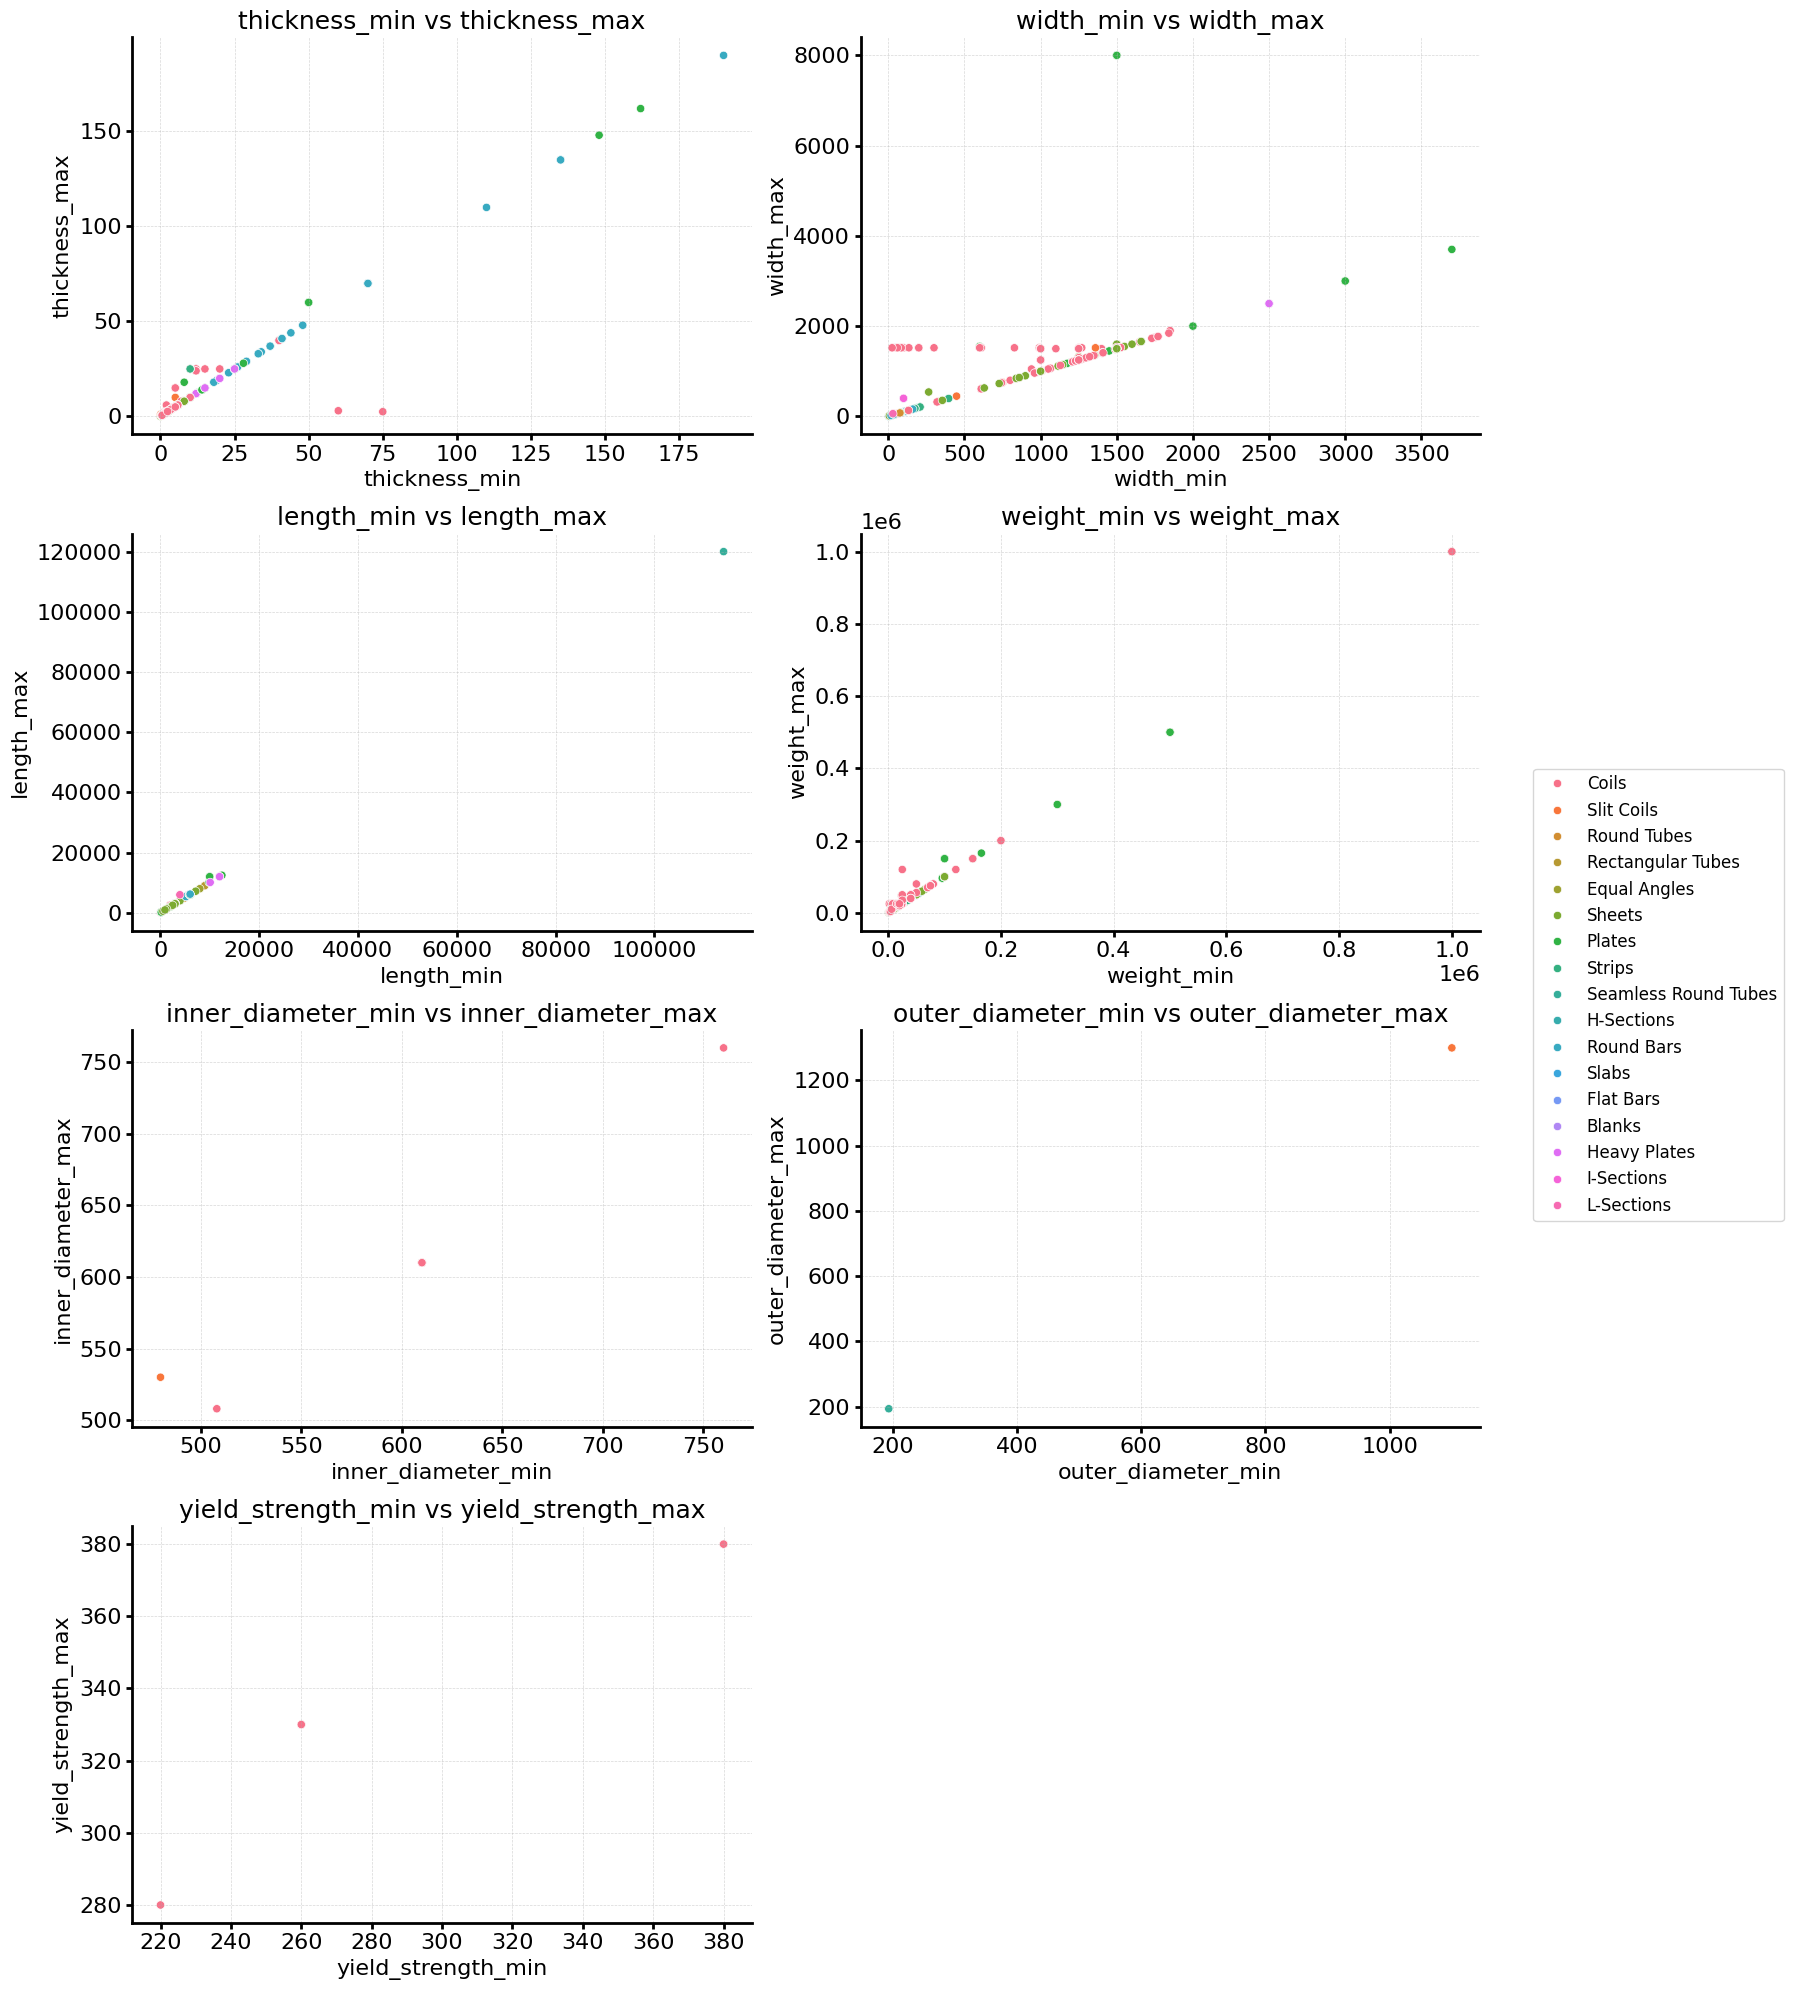

In [14]:
# Define your variable groups
var_groups = [
    ['thickness_min', 'thickness_max'],
    ['width_min', 'width_max'],
    ['length_min', 'length_max'],
    ['weight_min', 'weight_max'],
    ['inner_diameter_min', 'inner_diameter_max'],
    ['outer_diameter_min', 'outer_diameter_max'],
    ['yield_strength_min', 'yield_strength_max']
]


plot_scatter_for_variable_groups(df_merged, var_groups)

Fix thickness

In [15]:
# wrong thickness spotted (thickness_min > thickness_max)
mask =df_merged[df_merged['thickness_min'] > df_merged['thickness_max']].index
df_merged.loc[mask, ['thickness_min']] = df_merged.loc[mask, ['thickness_max']].values

# Input missing form on the basis of thickness
df_merged.loc[df_merged['thickness_min'] == 22.0, 'form'] = 'Coils'

Clean width

In [16]:
# founded unrealistic width of 8000, I input these values with the width min 
mask = df_merged['width_max'] == 8000
df_merged.loc[mask, 'width_max'] = df_merged.loc[mask, 'width_min']

# I found that all entries with width_max and width_min = 1520 are Coils, I will impute missing form with Coils
df_merged.loc[(df_merged['width_max'] == 1520) & (df_merged['form'] == 'None'), 'form'] = 'Coils'

Clean length

In [17]:
# Fix wrong max and min length by dividing by 10 those > 50000
mask = df_merged['length_min'] > 50000
df_merged.loc[mask, 'length_min'] = df_merged.loc[mask, 'length_min'] / 10
df_merged.loc[mask, 'length_max'] = df_merged.loc[mask, 'length_max'] / 10


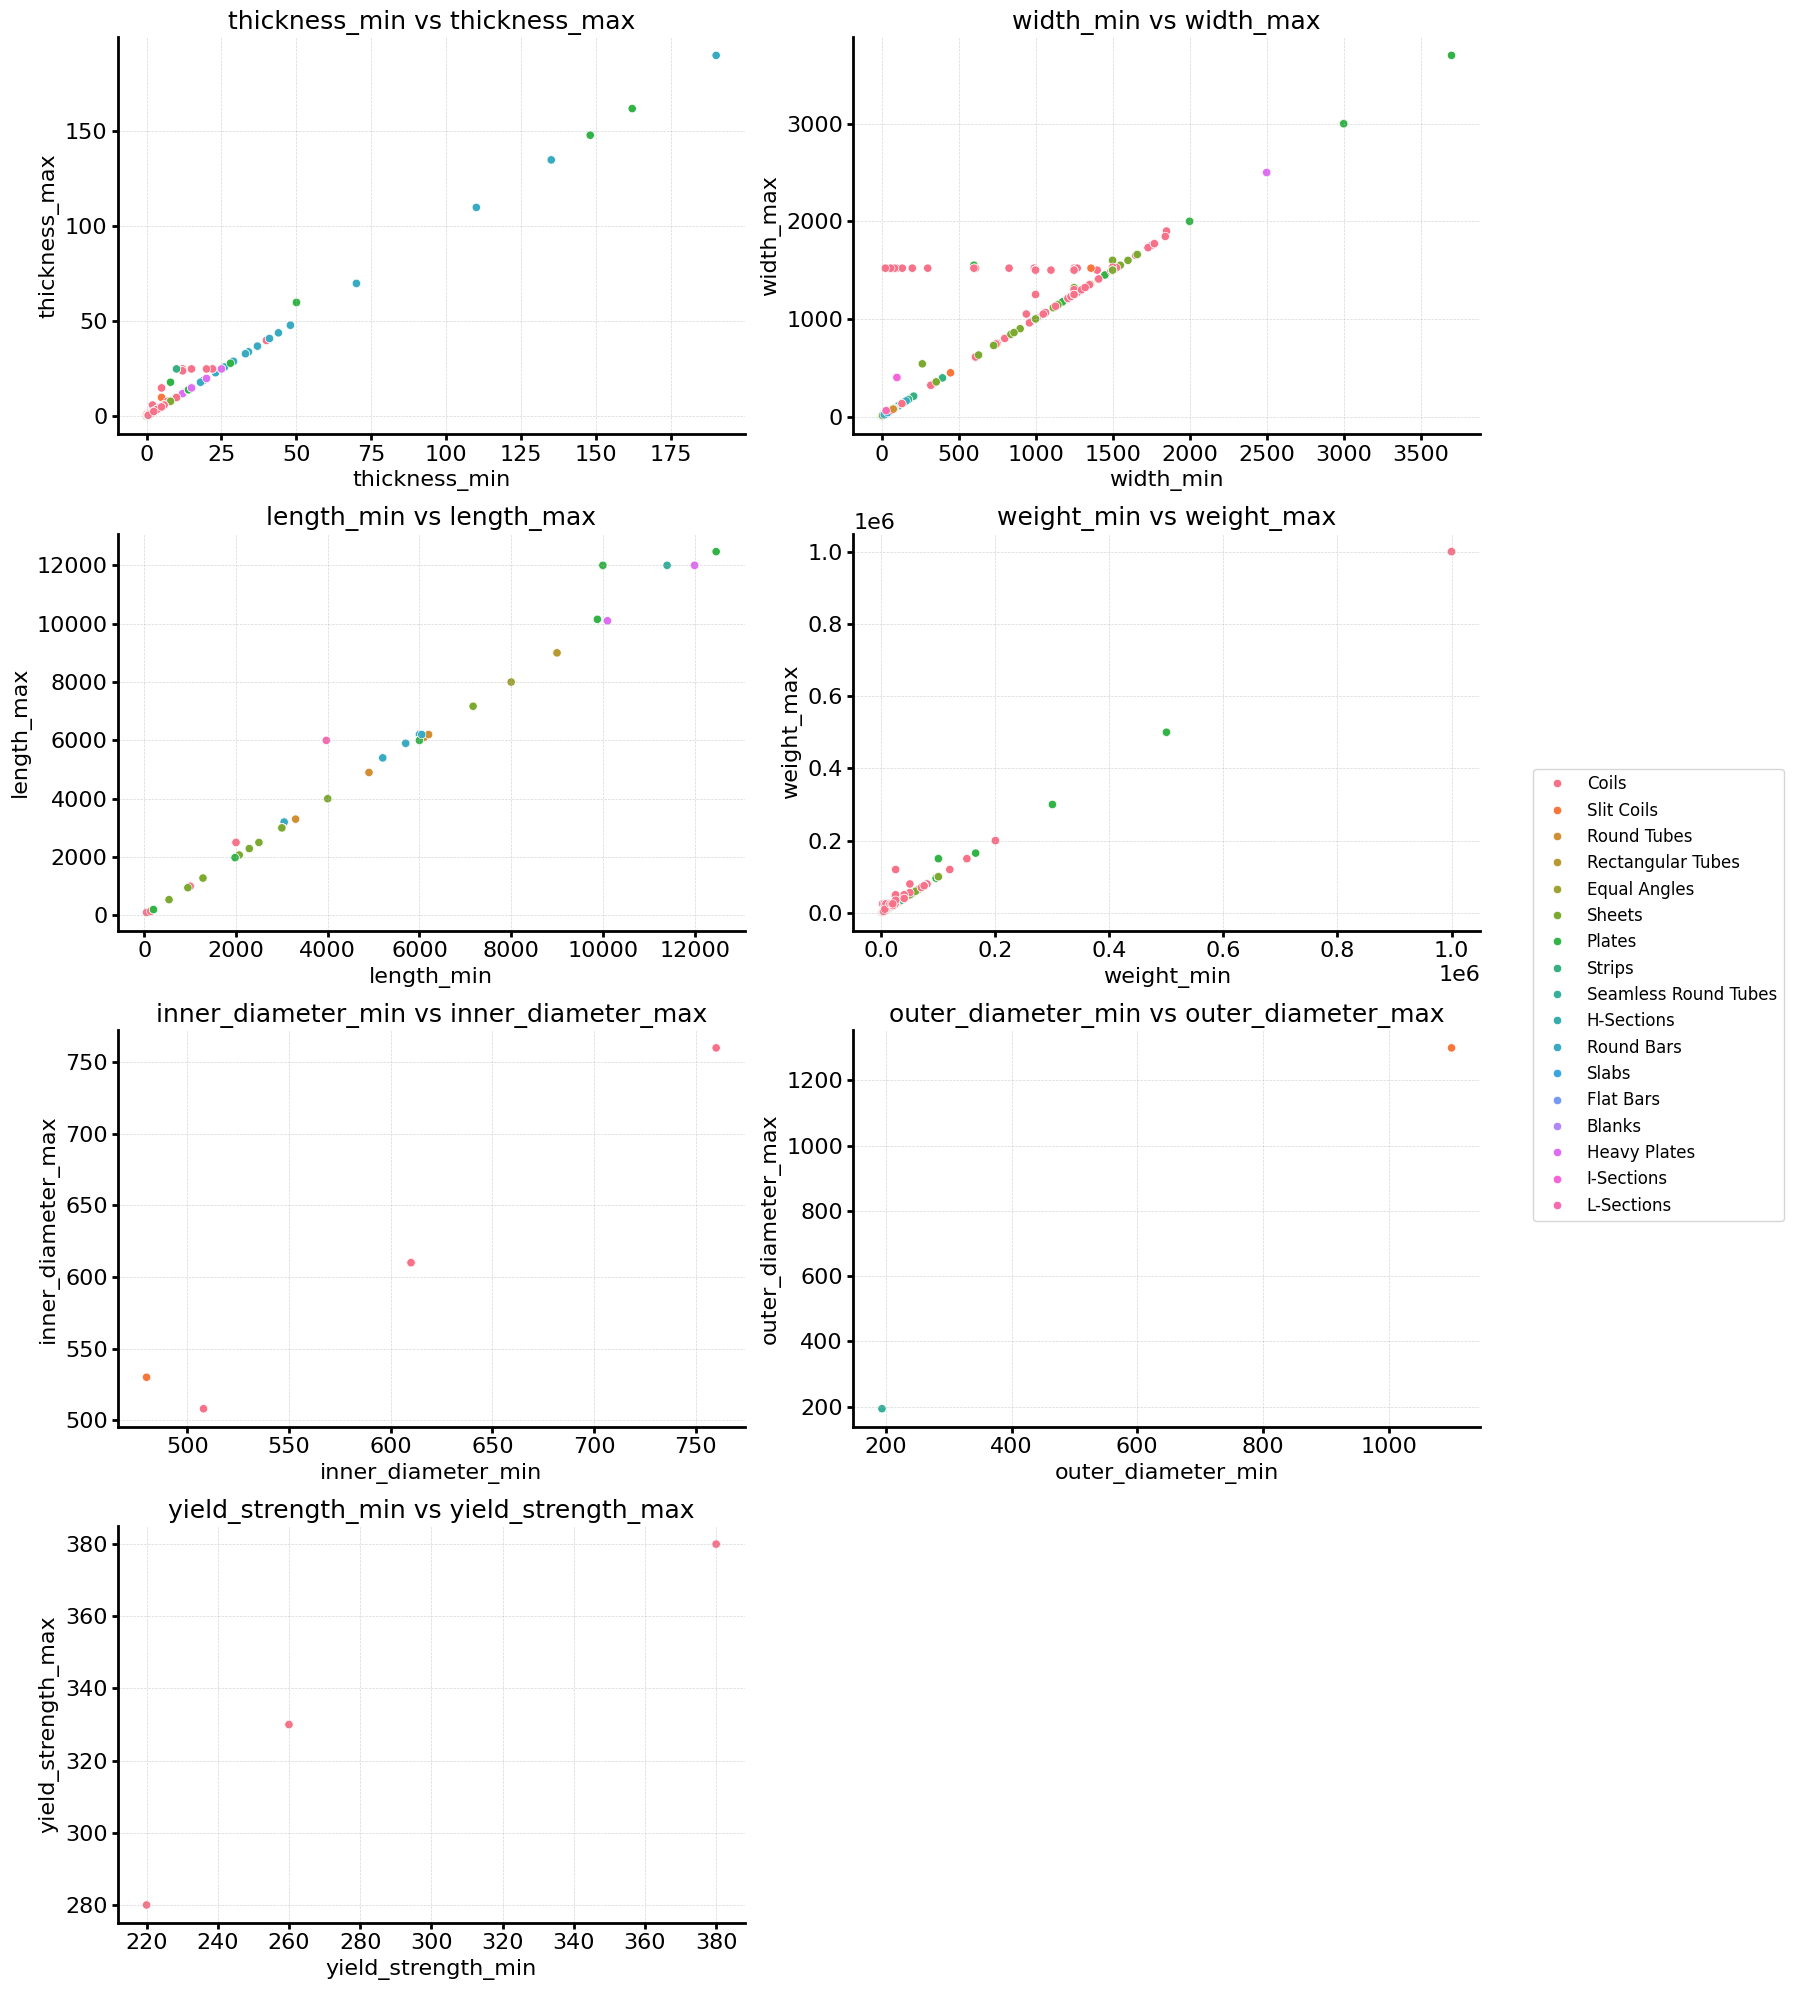

In [18]:
plot_scatter_for_variable_groups(df_merged, var_groups)

Clean Weight

In [19]:
# Some weight are unrealistics. I will divide by 10 those weight > 200000
mask = df_merged['weight_max'] > 200000
df_merged.loc[mask, 'weight_min'] = df_merged.loc[mask, 'weight_min'] / 10
df_merged.loc[mask, 'weight_max'] = df_merged.loc[mask, 'weight_max'] / 10


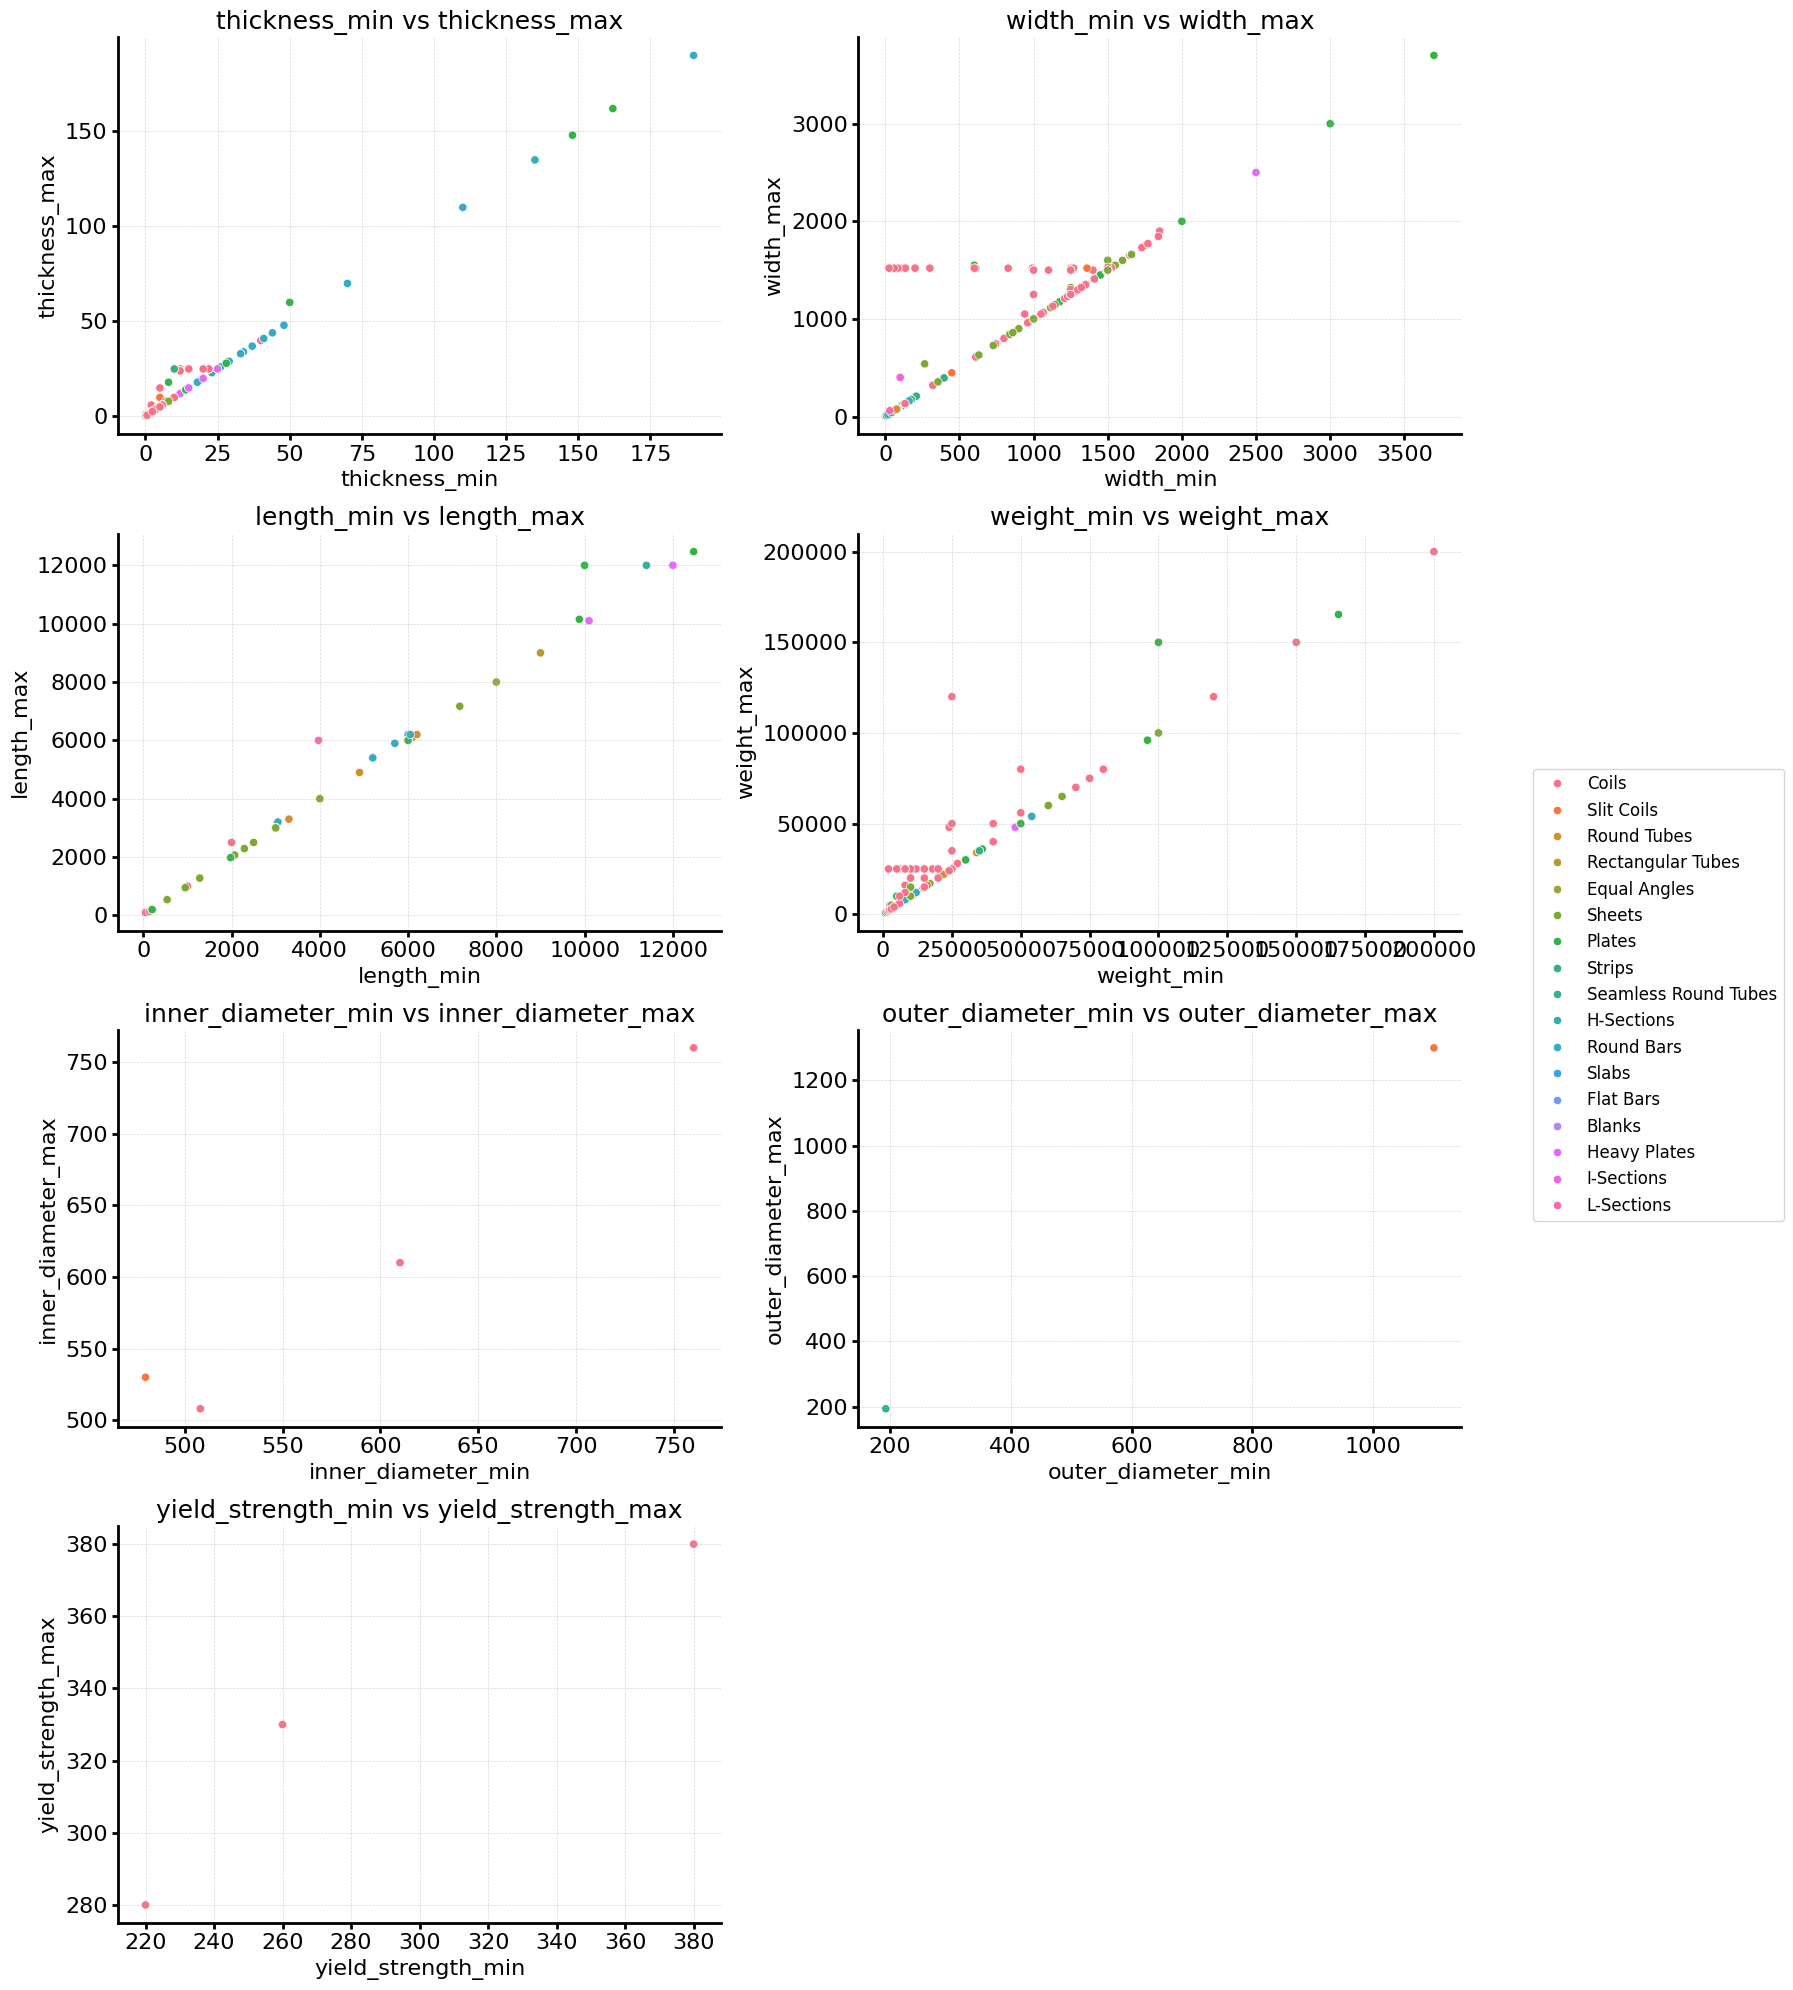

In [20]:
plot_scatter_for_variable_groups(df_merged, var_groups)

Singleton dimension

In [21]:
# Manage singleton dimensions 
dimension_cols = [
    'thickness',
    'width',
    'length',
    'weight',
    'inner_diameter',
    'outer_diameter',
    'yield_strength',
    'tensile_strength'
]
    
for col in dimension_cols:
    df_merged = fill_singleton_dimensions(df_merged, col)

In [22]:
df_merged['width_max'].max()

np.float64(3700.0)

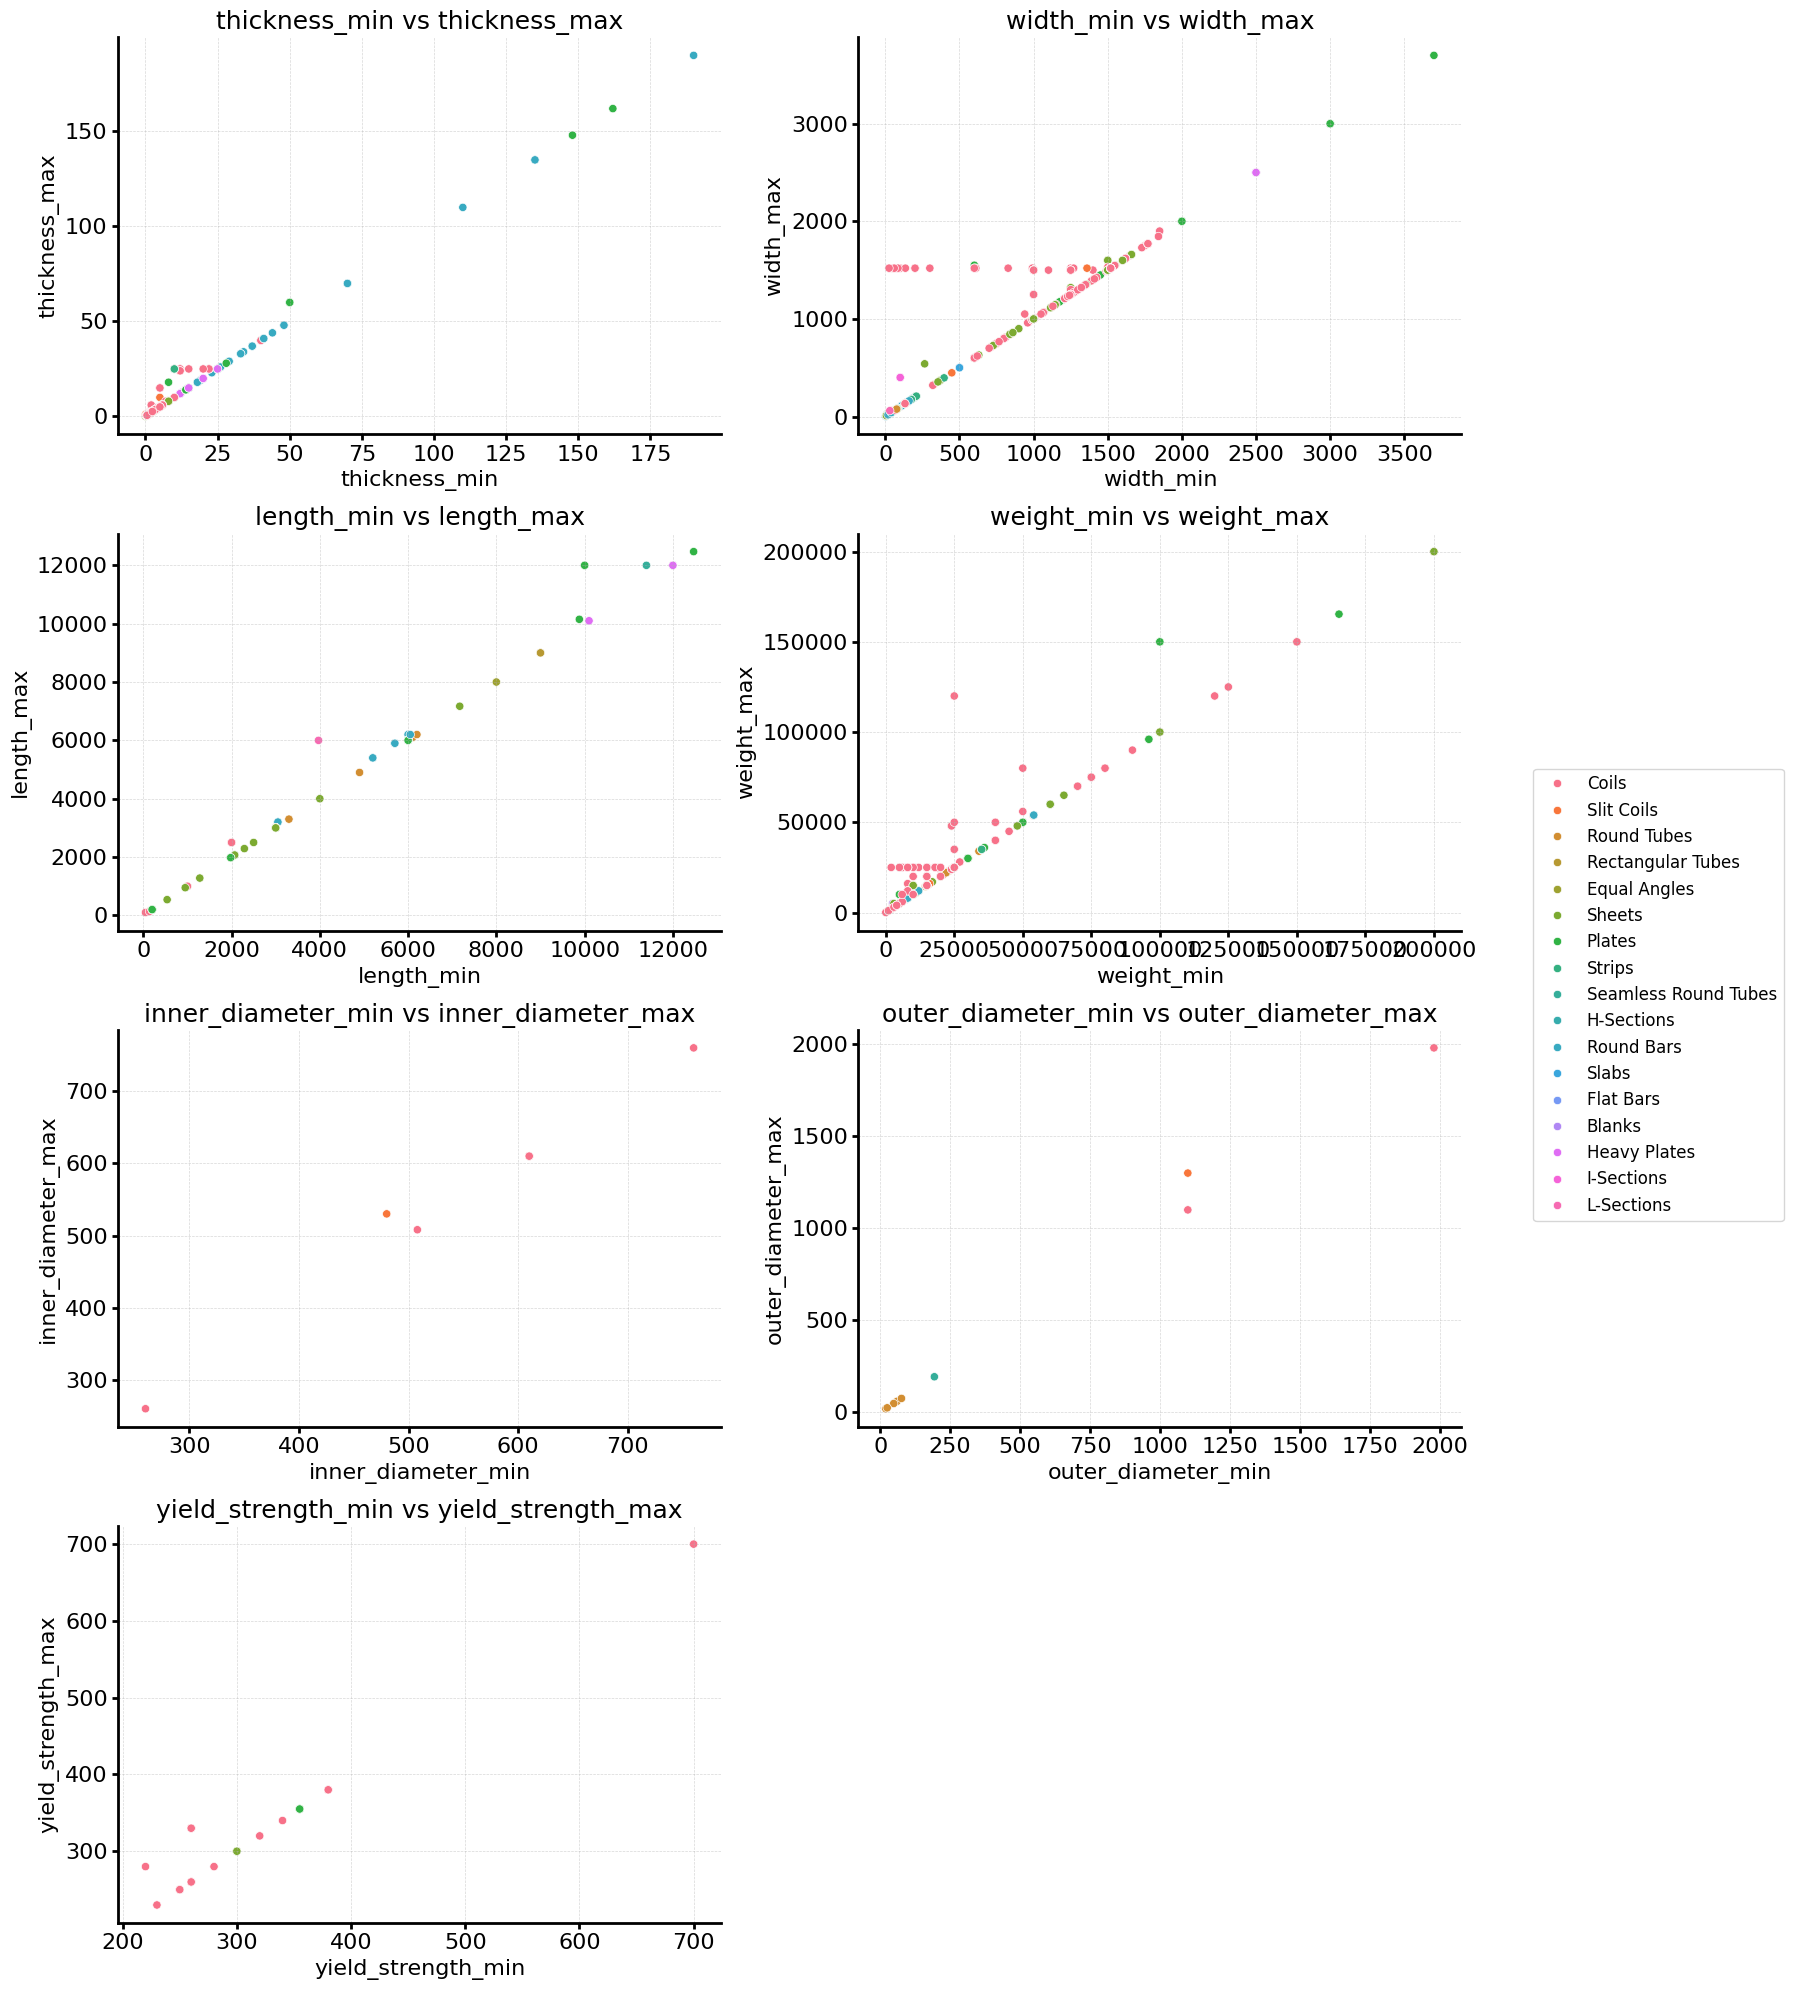

In [23]:
# Define your variable groups
var_groups = [
    ['thickness_min', 'thickness_max'],
    ['width_min', 'width_max'],
    ['length_min', 'length_max'],
    ['weight_min', 'weight_max'],
    ['inner_diameter_min', 'inner_diameter_max'],
    ['outer_diameter_min', 'outer_diameter_max'],
    ['yield_strength_min', 'yield_strength_max']
]


plot_scatter_for_variable_groups(df_merged, var_groups)

In [ ]:
# save to csv
df_merged.to_csv('outputs/task_2_output.csv', index=False)

NameError: name 'df' is not defined

# Run Analyses

In [ ]:
# Check grade properties columns sparsity
all_grade_properties_cols = ['carbon_C_mid',
       'manganese_Mn_mid', 'silicon_Si_mid', 'sulfur_S_mid',
       'phosphorus_P_mid', 'chromium_Cr_mid', 'nickel_Ni_mid',
       'molybdenum_Mo_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
       'titanium_Ti_mid', 'niobium_Nb_mid', 'boron_B_mid', 'nitrogen_N_mid',
       'tensile_strength_Rm_mid', 'yield_strength_RE_RP0.2_mid',
       'elongation_A%_mid', 'hardness_HB_HV_HRC_mid', 'Nb_V_Ti_others_mid'
      ]

sparsity = df_merged[all_grade_properties_cols].isnull().mean() * 100
print(sparsity)

grade_properties_cols = [col for col in all_grade_properties_cols if sparsity[col] < 75]

def run_grade_similarity(df, row1, row2, grade_properties_vars, distance_type='cosine'):
    vec1, vec2 = [], []
    for col in grade_properties_vars:
        val1, val2 = row1[col], row2[col]
        if not (pd.isna(val1) or pd.isna(val2)):
            # Normalize by column range
            col_min = df[col].min()
            col_range = df[col].max() - col_min
            if col_range > 0:
                vec1.append((val1 - col_min) / col_range)
                vec2.append((val2 - col_min) / col_range)
    
    if not vec1:
        return 0.0
    
    vec1, vec2 = np.array(vec1), np.array(vec2)

    if distance_type == 'cosine':
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    elif distance_type == 'euclidean':
        distance = np.linalg.norm(vec1 - vec2)
        return 1 - (distance / np.sqrt(len(vec1)))
    return 0.0


def categorical_similarity(val1, val2):
    if pd.isna(val1) and pd.isna(val2):
        return 1
    elif pd.isna(val1) or pd.isna(val2):
        return 0
    else:
        return 1 if val1 == val2 else 0

def run_categorical_similarity(row1, row2, dims):
    cat_matches = []
    for dim in dims:
        sim = categorical_similarity(row1[dim], row2[dim])
        if sim is not None:  
            cat_matches.append(sim)
    
    return sum(cat_matches) / len(cat_matches) if cat_matches else 0.0


def dimension_similarity(min1, max1, min2, max2, type='iou'):
    # Handle NaN cases
    nan1 = pd.isna(min1) or pd.isna(max1)
    nan2 = pd.isna(min2) or pd.isna(max2)
    
    if nan1 and nan2:
        return 1.0  
    elif nan1 or nan2:
        return 0.0 
    
    if min1 == max1 and min2 == max2:
        return 1.0 if min1 == min2 else 0.0

    if type == 'iou':
        intersection = max(0, min(max1, max2) - max(min1, min2))
        union = max(max1, max2) - min(min1, min2)
        return intersection / union if union > 0 else 0
    elif type == 'distance':
        center1 = (min1 + max1) / 2
        center2 = (min2 + max2) / 2
        distance = abs(center1 - center2)
        return np.round(np.exp(-distance / max(abs(center1), abs(center2), 1)), 2)

    return 0

def run_dimension_similarity(row1, row2, dims, type='iou'):
    ious = []
    for dim in dims:
        min_col = f"{dim}_min"
        max_col = f"{dim}_max"
        iou = dimension_similarity(
            row1[min_col], row1[max_col],
            row2[min_col], row2[max_col], type=type
        )
        ious.append(iou)
    
    return sum(ious) / len(ious) if ious else 1.0


# Test the functions
ablations = ['categories', 'properties'] 
df = df_merged.copy()

dimensions_matrix = np.zeros((len(df), len(df)))
# categories_matrix = np.zeros((len(df), len(df)))
# properties_matrix = np.zeros((len(df), len(df)))
grade_property_distance = 'euclidean'

for i in range(len(df)):
    if i % 20 == 0:
        print(f"Processing row {i}/{len(df)}")
    for j in range(len(df)):
        if i != j:
            if 'dimensions' not in ablations:
                sim_iou = run_dimension_similarity(df.iloc[i], df.iloc[j],  dims=dimensions_vars, type='iou')
                dimensions_matrix[i, j] = sim_iou
            if 'categories' not in ablations:
                sim_cat = run_categorical_similarity(df.iloc[i], df.iloc[j], dims=categorical_vars)
                categories_matrix[i, j] = sim_cat
            if 'properties' not in ablations:
                sim_prop = run_grade_similarity(df_merged, df.iloc[i], df.iloc[j], grade_properties_vars=grade_properties_vars, distance_type=grade_property_distance)
                properties_matrix[i, j] = sim_prop
        else:
            if 'dimensions' not in ablations:
                dimensions_matrix[i, j] = 1.0
            if 'categories' not in ablations:
                categories_matrix[i, j] = 1.0
            if 'properties' not in ablations:
                properties_matrix[i, j] = 1.0   

Processing row 0/941


NameError: name 'dimensions_vars' is not defined

<Axes: >

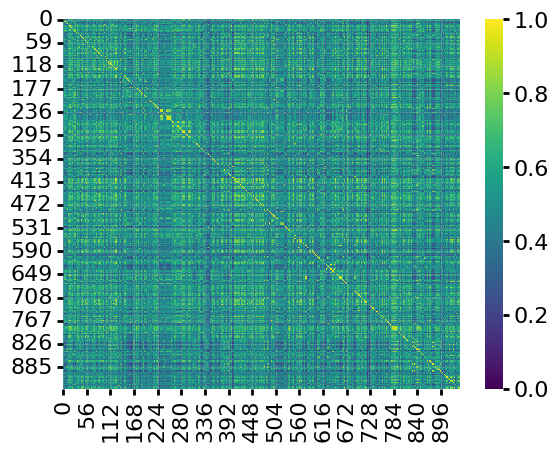

In [ ]:
weights = [1, 1, 1]
combined_similarity = ((properties_matrix*weights[0] + categories_matrix*weights[1] + dimensions_matrix*weights[2])/(3)).round(3)
combined_similarity[:10, :5]
sns.heatmap(combined_similarity, cmap='viridis')

<Axes: >

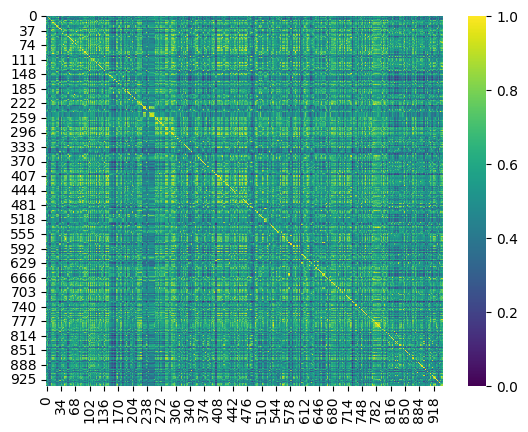

In [ ]:
weights = [1, 1, 1]
combined_similarity = ((properties_matrix*weights[0] + categories_matrix*weights[1] + dimensions_matrix*weights[2])/(3)).round(3)
combined_similarity[:10, :5]
sns.heatmap(combined_similarity, cmap='viridis')

array([[1.   , 0.494, 0.505, 0.482, 0.497],
       [0.494, 1.   , 0.593, 0.423, 0.423],
       [0.505, 0.593, 1.   , 0.281, 0.281],
       [0.482, 0.423, 0.281, 1.   , 0.867],
       [0.497, 0.423, 0.281, 0.867, 1.   ],
       [0.491, 0.423, 0.281, 0.867, 0.867],
       [0.341, 0.494, 0.559, 0.415, 0.415],
       [0.341, 0.494, 0.559, 0.415, 0.415],
       [0.381, 0.494, 0.467, 0.681, 0.681],
       [0.407, 0.561, 0.492, 0.615, 0.615]])

# Run Analyses

In [24]:
# Check grade properties columns sparsity
all_grade_properties_vars = ['carbon_C_mid',
       'manganese_Mn_mid', 'silicon_Si_mid', 'sulfur_S_mid',
       'phosphorus_P_mid', 'chromium_Cr_mid', 'nickel_Ni_mid',
       'molybdenum_Mo_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
       'titanium_Ti_mid', 'niobium_Nb_mid', 'boron_B_mid', 'nitrogen_N_mid',
       'tensile_strength_Rm_mid', 'yield_strength_RE_RP0.2_mid',
       'elongation_A%_mid', 'hardness_HB_HV_HRC_mid', 'Nb_V_Ti_others_mid'
      ]

sparsity = df_merged[all_grade_properties_vars].isnull().mean() * 100
print(sparsity)

grade_properties_vars = [col for col in all_grade_properties_vars if sparsity[col] < 75]
categorical_vars = ['coating_x', 'finish', 'surface_type', 'surface_protection', 'form']
dimensions_vars = ['length', 'width', 'thickness', 'weight', 'inner_diameter']

carbon_C_mid                    0.106270
manganese_Mn_mid                0.106270
silicon_Si_mid                 42.826780
sulfur_S_mid                    1.275239
phosphorus_P_mid                1.275239
chromium_Cr_mid                93.304995
nickel_Ni_mid                  97.662062
molybdenum_Mo_mid              95.642933
vanadium_V_mid                 75.876727
aluminum_Al_mid                42.614240
titanium_Ti_mid                75.557917
niobium_Nb_mid                 75.664187
boron_B_mid                    99.256111
nitrogen_N_mid                 85.547290
tensile_strength_Rm_mid         0.212540
yield_strength_RE_RP0.2_mid     1.275239
elongation_A%_mid               2.125399
hardness_HB_HV_HRC_mid         94.580234
Nb_V_Ti_others_mid             88.841658
dtype: float64


In [ ]:
def get_top_n_similarities(similarity_matrix, n=5):
    similarity_no_perfect = similarity_matrix.copy()
    similarity_no_perfect[similarity_no_perfect == 1.0] = -np.inf
    top_n_indices = np.argsort(-similarity_no_perfect, axis=1)[:, :n]
    top_n_values = np.take_along_axis(similarity_matrix, top_n_indices, axis=1)
    return top_n_indices, top_n_values

top_n_indices, top_n_values = get_top_n_similarities(combined_similarity, n=3)

def create_output_csv(df, top_n_indices, top_n_values, output_path='outputs/task_2_similarities.csv'):
    results = []
    for idx in range(len(df)):
        similar_indices = top_n_indices[idx]
        similar_values = top_n_values[idx]
        for sim_idx, sim_val in zip(similar_indices, similar_values):
            results.append({
                'index':idx,
                'RFQ_ID': df.iloc[idx]['id'],
                'Similar_RFQ_ID': df.iloc[sim_idx]['id'],
                'Similarity_Score': round(float(sim_val), 3),
            })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False, float_format='%.3f')
    print(f"Similarity results saved to {output_path}")

create_output_csv(df_merged, top_n_indices, top_n_values)

Similarity results saved to outputs/task_2_similarities.csv


# Further Analyses

In [ ]:

# def run_similarity_analysis(grade_property_distance, dimensions_type, ablations, weights, df, dimensions_vars, categorical_vars, grade_properties_vars):
#     """ Run similarity analysis with specified parameters. """
#     dimensions_matrix = np.zeros((len(df), len(df)))
#     categories_matrix = np.zeros((len(df), len(df)))
#     properties_matrix = np.zeros((len(df), len(df)))

#     for i in range(len(df)):
#         if i % 20 == 0:
#             print(f"Processing row {i}/{len(df)}")
#         for j in range(len(df)):
#             if i != j:
#                 if 'dimensions' not in ablations:
#                     sim_iou = run_dimension_similarity(df.iloc[i], df.iloc[j],  dims=dimensions_vars, type=dimensions_type)
#                     dimensions_matrix[i, j] = sim_iou
#                 if 'categories' not in ablations:
#                     sim_cat = run_categorical_similarity(df.iloc[i], df.iloc[j], dims=categorical_vars)
#                     categories_matrix[i, j] = sim_cat
#                 if 'properties' not in ablations:
#                     sim_prop = run_grade_similarity(df, df.iloc[i], df.iloc[j], grade_properties_vars=grade_properties_vars, distance_type=grade_property_distance)
#                     properties_matrix[i, j] = sim_prop
#             else:
#                 if 'dimensions' not in ablations:
#                     dimensions_matrix[i, j] = 1.0
#                 if 'categories' not in ablations:
#                     categories_matrix[i, j] = 1.0
#                 if 'properties' not in ablations:
#                     properties_matrix[i, j] = 1.0   

#     combined_similarity = ((properties_matrix*weights[0] + categories_matrix*weights[1] + dimensions_matrix*weights[2])/(3-len(ablations))).round(3)

#     return combined_similarity


In [27]:
mat = run_similarity_analysis('euclidean', 'distance', ablations=[], weights=[1,1,1], df=df_merged, dimensions_vars=dimensions_vars, categorical_vars=categorical_vars, grade_properties_vars=grade_properties_vars)

Processing row 0/941


NameError: name 'run_dimension_similarity' is not defined

In [27]:
# Check grade properties columns sparsity
all_grade_properties_vars = ['carbon_C_mid',
       'manganese_Mn_mid', 'silicon_Si_mid', 'sulfur_S_mid',
       'phosphorus_P_mid', 'chromium_Cr_mid', 'nickel_Ni_mid',
       'molybdenum_Mo_mid', 'vanadium_V_mid', 'aluminum_Al_mid',
       'titanium_Ti_mid', 'niobium_Nb_mid', 'boron_B_mid', 'nitrogen_N_mid',
       'tensile_strength_Rm_mid', 'yield_strength_RE_RP0.2_mid',
       'elongation_A%_mid', 'hardness_HB_HV_HRC_mid', 'Nb_V_Ti_others_mid'
      ]

sparsity = df_merged[all_grade_properties_vars].isnull().mean() * 100
print(sparsity)

grade_properties_vars = [col for col in all_grade_properties_vars if sparsity[col] < 75]
categorical_vars = ['coating_x', 'finish', 'surface_type', 'surface_protection', 'form']
dimensions_vars = ['length', 'width', 'thickness', 'weight', 'inner_diameter']

# Define explorations dictionary
explorations = {
    "baseline": {
        "distance_type": 'euclidean', 
        "similarity_type": 'distance', 
        "ablations": [], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "iou": {
        "distance_type": 'euclidean', 
        "similarity_type": 'iou',
        "ablations": [], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "reweighted": {
        "distance_type": 'euclidean', 
        "similarity_type": 'distance', 
        "ablations": [], 
        "weights": [3, 2, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "cosine": {
        "distance_type": 'cosine', 
        "similarity_type": 'distance', 
        "ablations": [], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "no_dimensions": {
        "distance_type": 'euclidean', 
        "similarity_type": 'distance', 
        "ablations": ["dimensions"], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "no_categories": {
        "distance_type": 'euclidean', 
        "similarity_type": 'distance', 
        "ablations": ["categories"], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    },
    "no_properties": {
        "distance_type": 'euclidean', 
        "similarity_type": 'distance', 
        "ablations": ["properties"], 
        "weights": [1, 1, 1], 
        "df": df_merged, 
        "dimensions_vars": dimensions_vars, 
        "categorical_vars": categorical_vars, 
        "grade_properties_vars": grade_properties_vars
    }
}

# Run analysis
matrices = {}
for exp_name, exp_params in explorations.items():
    print(f"Running run_similarity_analysis for: {exp_name} condition")
    
    matrices[exp_name] = run_similarity_analysis(
        exp_params['distance_type'],    
        exp_params['similarity_type'],  
        ablations=exp_params['ablations'],
        weights=exp_params['weights'],
        df=exp_params['df'],
        dimensions_vars=exp_params['dimensions_vars'],
        categorical_vars=exp_params['categorical_vars'],
        grade_properties_vars=exp_params['grade_properties_vars']
    )


# Store results
import pickle
with open('outputs/similarity_matrices.pkl', 'wb') as f:
    pickle.dump(matrices, f)


carbon_C_mid                    0.106270
manganese_Mn_mid                0.106270
silicon_Si_mid                 42.826780
sulfur_S_mid                    1.275239
phosphorus_P_mid                1.275239
chromium_Cr_mid                93.304995
nickel_Ni_mid                  97.662062
molybdenum_Mo_mid              95.642933
vanadium_V_mid                 75.876727
aluminum_Al_mid                42.614240
titanium_Ti_mid                75.557917
niobium_Nb_mid                 75.664187
boron_B_mid                    99.256111
nitrogen_N_mid                 85.547290
tensile_strength_Rm_mid         0.212540
yield_strength_RE_RP0.2_mid     1.275239
elongation_A%_mid               2.125399
hardness_HB_HV_HRC_mid         94.580234
Nb_V_Ti_others_mid             88.841658
dtype: float64
Running run_similarity_analysis for: baseline condition
Processing row 0/941
Processing row 20/941
Processing row 40/941
Processing row 60/941
Processing row 80/941
Processing row 100/941
Processing row 120

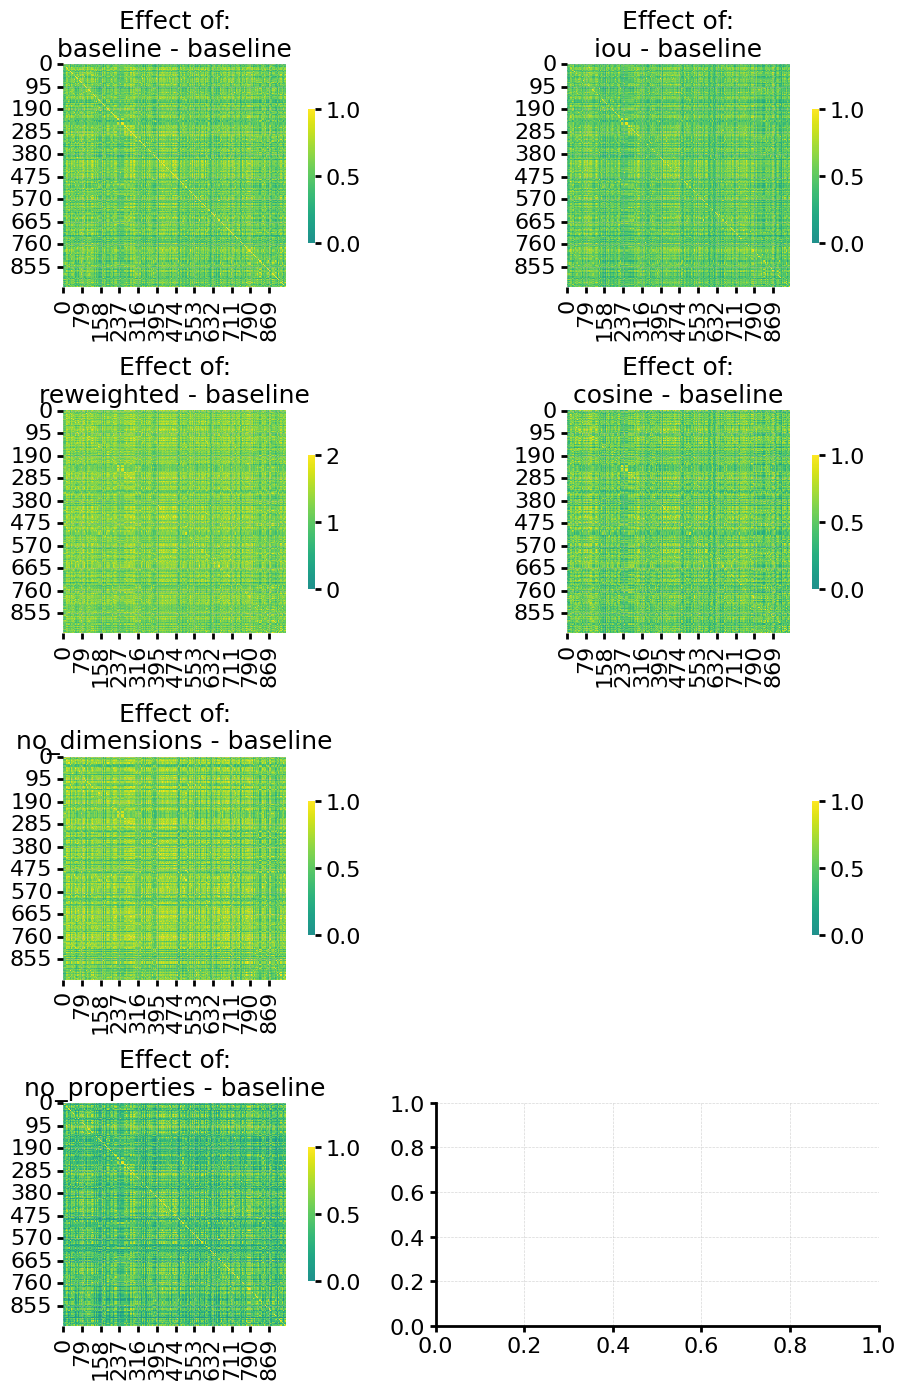

In [29]:
# Create subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 14))
axes = axes.flatten()

baseline = matrices['baseline']

for i, exp_name in enumerate(matrices.keys()):
    diff = matrices[exp_name] - baseline
    sns.heatmap(matrices[exp_name], ax=axes[i], cmap='viridis', center=0, square=True, 
                cbar_kws={'shrink': 0.6})
    axes[i].set_title(f'Effect of:\n{exp_name} - baseline')

# Hide the 6th subplot since you only have 5
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform

import numpy as np
import pandas as pd

def fast_grade_similarity(df, grade_properties_vars, distance_type='cosine'):
    """
    Optimized version that respects missing value logic from original function.
    Pre-normalizes data and uses numpy arrays for faster computation.
    """
    n = len(df)
    similarity_matrix = np.zeros((n, n))
    
    # Pre-normalize all data once
    data_normalized = df[grade_properties_vars].copy()
    for col in grade_properties_vars:
        col_min = data_normalized[col].min()
        col_range = data_normalized[col].max() - col_min
        if col_range > 0:
            data_normalized[col] = (data_normalized[col] - col_min) / col_range
        else:
            data_normalized[col] = 0
    
    # Convert to numpy arrays for faster access
    data_array = data_normalized.values
    is_nan = pd.isna(data_normalized).values
    
    # Compute similarities
    for i in range(n):
        if i % 100 == 0:
            print(f"Processing row {i}/{n}")
        similarity_matrix[i, i] = 1.0  # Diagonal
        
        for j in range(i + 1, n):
            # Find columns valid for both rows
            valid_mask = ~(is_nan[i] | is_nan[j])
            
            if not valid_mask.any():
                similarity = 0.0
            else:
                vec1 = data_array[i, valid_mask]
                vec2 = data_array[j, valid_mask]
                
                if distance_type == 'cosine':
                    norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
                    similarity = 0.0 if norm1 == 0 or norm2 == 0 else np.dot(vec1, vec2) / (norm1 * norm2)
                elif distance_type == 'euclidean':
                    distance = np.linalg.norm(vec1 - vec2)
                    similarity = 1 - (distance / np.sqrt(len(vec1)))
                else:
                    similarity = 0.0
            
            # Fill both sides of matrix
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity
    
    return similarity_matrix

def fast_categorical_similarity(df, categorical_vars):
    """Vectorized computation of categorical similarities."""
    n = len(df)
    similarity_matrix = np.zeros((n, n))
    
    for var in categorical_vars:
        # Create a matrix where entry (i,j) is 1 if values match, 0 otherwise
        values = df[var].values
        # Handle NaN values
        nan_mask = pd.isna(values)
        
        # Broadcasting to create comparison matrix
        matches = (values[:, None] == values[None, :])
        
        # Handle NaN cases: NaN == NaN -> 1, NaN != value -> 0
        nan_both = nan_mask[:, None] & nan_mask[None, :]
        nan_either = (nan_mask[:, None] | nan_mask[None, :]) & ~nan_both
        
        matches = matches & ~nan_either  # Remove NaN mismatches
        matches = matches | nan_both     # Add back NaN-NaN matches
        
        similarity_matrix += matches.astype(float)
    
    # Average across variables
    return similarity_matrix / len(categorical_vars)

def fast_dimension_similarity_iou(df, dimensions_vars):
    """Vectorized IoU computation for dimension ranges."""
    n = len(df)
    similarity_matrix = np.zeros((n, n))
    
    for dim in dimensions_vars:
        min_col = f"{dim}_min"
        max_col = f"{dim}_max"
        
        mins = df[min_col].values
        maxs = df[max_col].values
        
        # Vectorized IoU computation using broadcasting
        # intersection = max(0, min(max1, max2) - max(min1, min2))
        intersection = np.maximum(0, 
            np.minimum(maxs[:, None], maxs[None, :]) - 
            np.maximum(mins[:, None], mins[None, :])
        )
        
        # union = max(max1, max2) - min(min1, min2)
        union = (np.maximum(maxs[:, None], maxs[None, :]) - 
                np.minimum(mins[:, None], mins[None, :]))
        
        # Handle division by zero
        iou = np.divide(intersection, union, out=np.zeros_like(union), where=union!=0)
        
        # Handle NaN cases
        nan_mask1 = pd.isna(mins) | pd.isna(maxs)
        nan_both = nan_mask1[:, None] & nan_mask1[None, :]
        nan_either = (nan_mask1[:, None] | nan_mask1[None, :]) & ~nan_both
        
        iou[nan_both] = 1.0
        iou[nan_either] = 0.0
        
        # Handle point ranges (min == max)
        point_mask1 = (mins == maxs)
        point_both = point_mask1[:, None] & point_mask1[None, :]
        point_matches = (mins[:, None] == mins[None, :]) & point_both
        iou[point_both] = point_matches[point_both].astype(float)
        
        similarity_matrix += iou
    
    # Average across dimensions
    return similarity_matrix / len(dimensions_vars)

def fast_similarity_analysis(df, dimensions_vars, categorical_vars, grade_properties_vars, 
                           distance_type='cosine', similarity_type='iou', 
                           ablations=[], weights=[1, 1, 1]):
    """Fast vectorized similarity analysis."""
    
    n = len(df)
    matrices = []
    active_weights = []
    
    if 'properties' not in ablations and grade_properties_vars:
        print("Computing property similarities...")
        properties_matrix = fast_grade_similarity(df, grade_properties_vars, distance_type)
        matrices.append(properties_matrix)
        active_weights.append(weights[0])
    
    if 'categories' not in ablations and categorical_vars:
        print("Computing categorical similarities...")
        categories_matrix = fast_categorical_similarity(df, categorical_vars)
        matrices.append(categories_matrix)
        active_weights.append(weights[1])
    
    if 'dimensions' not in ablations and dimensions_vars:
        print("Computing dimensional similarities...")
        if similarity_type == 'iou':
            dimensions_matrix = fast_dimension_similarity_iou(df, dimensions_vars)
        else:  # distance-based would need separate implementation
            dimensions_matrix = fast_dimension_similarity_iou(df, dimensions_vars)
        matrices.append(dimensions_matrix)
        active_weights.append(weights[2])
    
    if not matrices:
        return np.eye(n)  # Return identity matrix if no similarities computed
    
    # Weighted combination
    combined_similarity = np.zeros((n, n))
    total_weight = sum(active_weights)
    
    for matrix, weight in zip(matrices, active_weights):
        combined_similarity += matrix * (weight / total_weight)
    
    return np.round(combined_similarity, 3)

In [ ]:
mat = fast_similarity_analysis(df_merged, dimensions_vars, categorical_vars, grade_properties_vars, 
                           distance_type='euclidean', similarity_type='iou', 
                           ablations=[], weights=[1, 1, 1])

Computing property similarities...
Processing row 0/941
Processing row 100/941
Processing row 200/941
Processing row 300/941
Processing row 400/941
Processing row 500/941
Processing row 600/941
Processing row 700/941
Processing row 800/941
Processing row 900/941
Computing categorical similarities...
Computing dimensional similarities...


In [ ]:
sns.heatmap(mat, cmap='viridis')

array([[1.   , 0.436, 0.433, ..., 0.663, 0.626, 0.497],
       [0.436, 1.   , 0.588, ..., 0.384, 0.435, 0.402],
       [0.433, 0.588, 1.   , ..., 0.412, 0.551, 0.485],
       ...,
       [0.663, 0.384, 0.412, ..., 1.   , 0.687, 0.663],
       [0.626, 0.435, 0.551, ..., 0.687, 1.   , 0.794],
       [0.497, 0.402, 0.485, ..., 0.663, 0.794, 1.   ]], shape=(941, 941))